In [1]:
# Cài đặt PyTorch Geometric và dependencies cho Kaggle (CUDA 11.8)
!pip install -q torch torchvision torchaudio
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q torch-geometric
!pip install -q scikit-learn pandas matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 22.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 87.0 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 47.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.8 MB/s eta 0:00:0000:01


In [2]:
!pip install hdbscan


In [29]:
# --- 1. Import
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

def load_data():
    # --- Load edge weights and wallet features ---
    edges = pd.read_csv("/kaggle/input/baai-kg-1/liquidated_edges.csv")
    features_df = pd.read_csv("/kaggle/input/baai-kg-1/wallet_features.csv").set_index("id")

    # Build wallet index and align features
    # Tập wallet ở features và tập wallet có trong edges
    wallets_in_edges = pd.Index(pd.concat([edges['source'], edges['target']]).unique())
    wallets_in_feats = features_df.index
    
    # 1) Lấy union (hợp nhất) 2 tập
    all_wallets = wallets_in_feats.union(wallets_in_edges)
    
    # 2) Reindex theo tập union, fill NaN = 0
    features_df = features_df.reindex(all_wallets).fillna(0)
    
    # Normalize features
    scaler = StandardScaler()
    features = scaler.fit_transform(features_df.values)
    x = torch.tensor(features, dtype=torch.float)

    # Create edge_index and edge_weight
    idx_map = {w:i for i,w in enumerate(wallets)}
    src = edges['source'].map(idx_map).values
    dst = edges['target'].map(idx_map).values
    edge_index = torch.tensor([src, dst], dtype=torch.long)
    # Make undirected
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
    w = edges['weight'].values
    edge_weight = torch.tensor(list(w) + list(w), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)
    return data, features_df, edges
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 128)
        self.conv2 = GCNConv(128, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight=edge_weight).relu()
        return self.conv2(x, edge_index, edge_weight=edge_weight)

def train_gae(data, in_channels, hidden_channels, num_epochs=100, lr=0.01):
    # Initialize model and optimizer
    encoder = GCNEncoder(in_channels, hidden_channels)
    model = GAE(encoder)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(1, num_epochs + 1):
        optimizer.zero_grad()
        # Encode with edge_weight support
        z = model.encode(data.x, data.edge_index, data.edge_weight)
        # Use standard reconstruction loss (PyG recon_loss does not accept edge_weight)
        loss = model.recon_loss(z, data.edge_index)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}")
    return model


In [32]:
data, wallet_features_df, edges = load_data()

In [33]:
len(wallet_features_df)

998

In [34]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GCNConv, GAE

in_channels = data.x.shape[1]
hidden_channels = 16
    # Train the GAE
trained_model = train_gae(data, in_channels, hidden_channels, num_epochs=2000, lr=0.005)

    # Get embeddings
trained_model.eval()
with torch.no_grad():
        z = trained_model.encode(data.x, data.edge_index, data.edge_weight)
    # z is a [num_nodes x hidden_channels] tensor of node embeddings
print("Training complete. Node embeddings shape:", z.shape)


Epoch 001, Loss: 1.5646
Epoch 010, Loss: 1.2871
Epoch 020, Loss: 1.2290
Epoch 030, Loss: 1.1336
Epoch 040, Loss: 1.0231
Epoch 050, Loss: 1.0296
Epoch 060, Loss: 0.9996
Epoch 070, Loss: 0.9900
Epoch 080, Loss: 0.9705
Epoch 090, Loss: 0.9711
Epoch 100, Loss: 0.9925
Epoch 110, Loss: 0.9702
Epoch 120, Loss: 0.9875
Epoch 130, Loss: 0.9821
Epoch 140, Loss: 0.9536
Epoch 150, Loss: 0.9655
Epoch 160, Loss: 0.9552
Epoch 170, Loss: 0.9429
Epoch 180, Loss: 0.9488
Epoch 190, Loss: 0.9565
Epoch 200, Loss: 0.9452
Epoch 210, Loss: 0.9723
Epoch 220, Loss: 0.9691
Epoch 230, Loss: 0.9399
Epoch 240, Loss: 0.9504
Epoch 250, Loss: 0.9610
Epoch 260, Loss: 0.9290
Epoch 270, Loss: 0.9213
Epoch 280, Loss: 0.9633
Epoch 290, Loss: 0.9238
Epoch 300, Loss: 0.9266
Epoch 310, Loss: 0.9250
Epoch 320, Loss: 0.9440
Epoch 330, Loss: 0.9230
Epoch 340, Loss: 0.9363
Epoch 350, Loss: 0.9208
Epoch 360, Loss: 0.9341
Epoch 370, Loss: 0.9513
Epoch 380, Loss: 0.9245
Epoch 390, Loss: 0.9453
Epoch 400, Loss: 0.9422
Epoch 410, Loss:

In [35]:
trained_model.eval()
with torch.no_grad():
    z = trained_model.encode(data.x, data.edge_index).cpu().numpy()  # Chuyển về CP


In [36]:
def compute_graph_features(edges, wallets):
    # Build weighted graph
    G = nx.from_pandas_edgelist(edges, 'source', 'target', edge_attr='weight', create_using=nx.DiGraph())
    # Compute features
    pr = nx.pagerank(G, weight='weight')
    deg = dict(G.degree(weight='weight'))
    indeg = dict(G.in_degree(weight='weight'))
    outdeg = dict(G.out_degree(weight='weight'))
    btwn = nx.betweenness_centrality(G, weight='weight')
    # Assemble DataFrame aligned with wallets
    df = pd.DataFrame(index=wallets)
    df['pagerank']    = pd.Series(pr)
    df['degree']      = pd.Series(deg)
    df['in_degree']   = pd.Series(indeg)
    df['out_degree']  = pd.Series(outdeg)
    df['betweenness'] = pd.Series(btwn)
    return df.fillna(0)

In [37]:
import pandas as pd
import numpy as np
import torch
import networkx as nx
from torch_geometric.data import Data
from sklearn.impute import SimpleImputer
from torch_geometric.nn import GCNConv, GAE

In [38]:
# Compute and normalize graph-level features
wallets = wallet_features_df.index
graph_feats = compute_graph_features(edges, wallets)
gf_scaled = StandardScaler().fit_transform(graph_feats.values)
imputer = SimpleImputer(strategy='mean')
gf_imputed = imputer.fit_transform(gf_scaled)

# Combine embeddings with graph-level features
combined_embedding = np.hstack([z, gf_imputed])

In [39]:
combined_embedding

array([[-0.28814811,  0.61278194,  0.27269772, ..., -0.11623211,
        -0.13695297,  0.        ],
       [-0.0841982 ,  0.8229928 ,  0.52201611, ..., -0.14989067,
        -0.13695297,  0.        ],
       [-0.89681548, -0.01648673, -0.26566327, ..., -0.14350008,
        -0.13695297,  0.        ],
       ...,
       [ 0.14177357, -0.12313685,  0.11220323, ..., -0.14989067,
        -0.12025456,  0.        ],
       [ 0.19741842,  0.01571828, -0.18754534, ..., -0.14989067,
        -0.13695297,  0.        ],
       [ 0.01135841, -0.22573441, -0.24356557, ...,  3.02006438,
        -0.13695297,  0.        ]])

In [42]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
best_k, best_score = None, -1
for k in range(2, 40):
        spec = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
        labels = spec.fit_predict(combined_embedding)
        score = silhouette_score(combined_embedding, labels)
        print(f"k={k}, silhouette={score:.4f}")
        if score > best_score:
            best_k, best_score = k, score
print(f"Best k: {best_k} with silhouette score {best_score:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=2, silhouette=-0.0928
k=3, silhouette=-0.0950


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=4, silhouette=-0.0192
k=5, silhouette=-0.0021


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=6, silhouette=0.0564
k=7, silhouette=-0.0148


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=8, silhouette=-0.0251
k=9, silhouette=-0.0210


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=10, silhouette=0.0055
k=11, silhouette=0.0243


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=12, silhouette=0.0569
k=13, silhouette=0.0514


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=14, silhouette=0.0287
k=15, silhouette=0.0457


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=16, silhouette=0.0464
k=17, silhouette=0.0551


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=18, silhouette=0.0684


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=19, silhouette=0.0762


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=20, silhouette=0.0875


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=21, silhouette=0.0971


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=22, silhouette=0.1032


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=23, silhouette=0.0933


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=24, silhouette=0.1150


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=25, silhouette=0.1195


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=26, silhouette=0.1286


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=27, silhouette=0.1341


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=28, silhouette=0.1405


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=29, silhouette=0.1322


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=30, silhouette=0.1354


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=31, silhouette=0.1307


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=32, silhouette=0.1234


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=33, silhouette=0.1244


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=34, silhouette=0.1193


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=35, silhouette=0.1199


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=36, silhouette=0.1241


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=37, silhouette=0.1221


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=38, silhouette=0.1129


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=39, silhouette=0.1139
Best k: 28 with silhouette score 0.1405


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


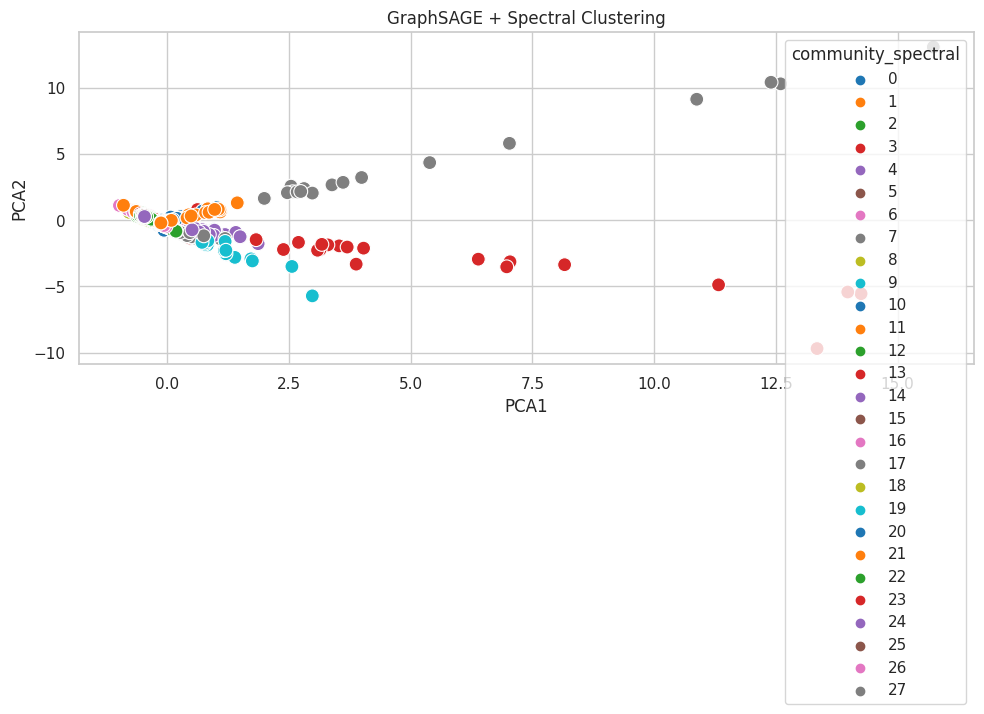

In [43]:
# PCA for visualization
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
import seaborn as sns
import matplotlib.pyplot as plt
X_pca = PCA(n_components=2).fit_transform(combined_embedding)

# Spectral Clustering
spectral = SpectralClustering(n_clusters=best_k, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
labels_spectral = spectral.fit_predict(combined_embedding)

# Create DataFrame for visualization
df_vis = pd.DataFrame({
    "PCA1": X_pca[:, 0],
    "PCA2": X_pca[:, 1],
    "community_spectral": labels_spectral,
    "wallet": wallets
})

# Plot results
sns.set(style="whitegrid", rc={"figure.figsize": (10, 6)})
sns.scatterplot(data=df_vis, x='PCA1', y='PCA2', hue='community_spectral', palette='tab10', s=100)
plt.title("GraphSAGE + Spectral Clustering")
plt.tight_layout()
plt.show()

In [44]:
w = {
    'num_deposit':          2,
    'total_deposit':       10,
    'num_borrow':          -2,
    'total_borrow':        -8,
    'num_repay':            2,
    'total_repay':          8,
    'num_withdraw':        -2,
    'total_withdraw':      -5,
    'num_liquidated':      -5,
    'total_liquidated':   -15,
    'num_liquidating':     -2,
    'total_liquidating':  -5,
    'num_contracts':        3,
    'num_projects':         3,
    'num_tweets':           1,
    'avg_likes':           0.5,
    'avg_retweets':        0.5,
    'num_hashtags':        0.5,
}


In [45]:
# Suppose df_embed.index is wallet ID and columns are [0,1,2,…,D-1]:
df_embed = pd.DataFrame(z, index=wallets)
df_embed["community"] = labels_spectral 
df_embed = (
    df_embed
    .rename_axis("wallet")              # make the index name explicit
    .reset_index()                      # bring wallet ID into a column
    .rename(columns=lambda c:          # rename every numeric col to "embed_#"
        f"embed_{c}" if isinstance(c, int) else c
    )
)


In [57]:
df = (
    df_embed
    .set_index("wallet")           # make wallet ID the index
    .join(wallet_features_df, how="left") # pull in every column from features_df by index
    .reset_index()                 # bring wallet ID back as a column
)

In [58]:
print(df[['wallet'] + list(w.keys())].head(10))

                                           wallet  num_deposit  total_deposit  \
0  0x1_0x0000000002a70a5a249ba633db4ee5fc9f90d611            0       0.000000   
1  0x1_0x000000fee13a103a10d593b9ae06b3e05f2e7e1c            0       0.000000   
2  0x1_0x00000639caea2f4991b946c1f68686e4df700000            0       0.000000   
3  0x1_0x000076a33ef6a2027f01f73f7dbb122a8f31f61d            0       0.000000   
4  0x1_0x00809b9263aab2856bf65be3d3bc3fcb9e19c1fb            0       0.000000   
5  0x1_0x00e36307236118b7d5ff9e1fa3a2506fd5257b8a            1       0.000000   
6  0x1_0x00ec8cb39d12f8686f674152a8fc586e04d12f4a            1      50.028948   
7  0x1_0x0177ffdf6b5c00ff8eab1a498ea10191ebc965db            0       0.000000   
8  0x1_0x01cc7ba4f67e102e8f789c2859e091cfca7bde35            2     514.348500   
9  0x1_0x01d35e1cbc52ce7599b5e3a70b6e2f595f534106            7    2636.774998   

   num_borrow  total_borrow  num_repay  total_repay  num_withdraw  \
0           0      0.000000          0 

In [59]:
# w is a dict, so w.keys() are your feature names
features = list(w.keys())

# And later when you do the dot‐product, turn w into a Series:
w_series = pd.Series(w)

feat_centroids = df.groupby("community")[features].mean()
feat_scores    = (feat_centroids * w_series).sum(axis=1)


In [66]:
best_comm = feat_scores.idxmax()
print("Community uy tín nhất:", best_comm)

Community uy tín nhất: 11


In [67]:
emb_cols = [c for c in df.columns if c.startswith("embed_")]
emb_centroids = df.groupby("community")[emb_cols].mean()
centroid = emb_centroids.loc[best_comm].values  # vector tâm

In [68]:
# 3) Tính khoảng cách Eucldiean từ mỗi ví tới tâm
def dist_to_centroid(row):
    return np.linalg.norm(row[emb_cols].values - centroid)

df["dist_to_best_comm"] = df.apply(dist_to_centroid, axis=1)

# 4) Chuyển khoảng cách thành credit score
#    Đầu tiên chuẩn hoá dist -> [0,1], sau đó đảo chiều (càng gần => score càng cao)
scaler = MinMaxScaler()
df["dist_norm"] = scaler.fit_transform(df[["dist_to_best_comm"]])

# emb_score = 1 - dist_norm  # nếu bạn chỉ dùng embedding
# Nếu muốn blend thêm feat_score_norm:
alpha = 0.7  # trọng số cho feature-based
beta  = 0.3  # trọng số cho embedding-based
df["composite"] = alpha * df["feat_score_norm"] + beta * (1 - df["dist_norm"])

# Cuối cùng map về thang 300–850
min_score, max_score = 300, 850
df["credit_score"] = min_score + df["composite"] * (max_score - min_score)

In [70]:
df

,wallet,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,...,avg_retweets,num_hashtags,emb_dist,emb_score,feat_score_norm,composite_raw,credit_score,dist_to_best_comm,dist_norm,composite
0,0x1_0x0000000002a70a5a249ba633db4ee5fc9f90d611,-0.288148,0.612782,0.272698,0.051639,-0.242926,0.021273,0.611817,0.054437,-0.320408,...,0.0000,0,6.778320e-01,0.927423,0.703073,0.770378,684.806635,4.714176,0.308342,0.699648
1,0x1_0x000000fee13a103a10d593b9ae06b3e05f2e7e1c,-0.084198,0.822993,0.522016,0.066127,-0.207009,-0.089779,0.717208,0.263017,-0.488356,...,0.0000,0,1.140732e+00,0.877858,0.000000,0.263358,414.720840,4.684986,0.304722,0.208583
2,0x1_0x00000639caea2f4991b946c1f68686e4df700000,-0.896815,-0.016487,-0.265663,-0.298782,-0.608998,-0.605407,0.210828,-0.611799,-0.254522,...,0.0000,0,6.847834e-01,0.926678,0.717509,0.780260,687.198940,4.868913,0.327528,0.703998
3,0x1_0x000076a33ef6a2027f01f73f7dbb122a8f31f61d,-0.322370,0.589526,0.097580,0.185119,-0.070400,-0.161263,0.443812,0.227040,-0.220140,...,0.0000,0,1.704935e+00,0.817448,0.703105,0.737408,683.312826,4.787794,0.317470,0.696932
4,0x1_0x00809b9263aab2856bf65be3d3bc3fcb9e19c1fb,0.293316,0.314936,0.549992,-0.395666,-0.443797,0.279635,0.081881,-0.029357,-0.226012,...,23.6625,0,1.268250e+00,0.864205,0.922345,0.904903,770.231639,4.665048,0.302250,0.854967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,0x1_0xfe8260a826dc1f6e606118a2069f564d7a50ae5f,0.036140,-0.753865,0.581450,-0.490286,-0.247059,-0.468574,-0.819536,-0.003617,-0.060075,...,23.6625,0,1.557011e+00,0.833286,0.558070,0.640635,617.776666,5.261805,0.376244,0.577776
994,0x1_0xff4daf5b899fa6914c0ae073fd2ac06024878139,0.096975,-0.126620,0.031515,-0.113570,-0.112668,-0.131266,-0.165958,-0.043496,-0.085755,...,0.0000,0,4.048757e-01,0.956649,0.558070,0.677643,630.179520,4.655570,0.301075,0.600326
995,0x1_0xffc0161955b6b62027ca808e55a6d91b0f22ef15,0.141774,-0.123137,0.112203,-0.052511,-0.080813,-0.089153,-0.153964,-0.063742,-0.061535,...,0.0000,0,4.358478e-01,0.953332,0.558070,0.676649,630.273269,4.650988,0.300507,0.600497
996,0x1_0xffe22aa0c8de8e998e13dc8160d05475a5200942,0.197418,0.015718,-0.187545,0.113881,0.322311,0.123939,-0.216459,-0.098734,0.573837,...,0.0000,0,2.686345e-08,1.000000,0.703075,0.792152,681.936085,4.854528,0.325744,0.694429


In [72]:
!pip install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 8.3 MB/s eta 0:00:00:00:01


In [ ]:
from neo4j import GraphDatabase
import pandas as pd

class WalletFeatureExporter:
    def __init__(self):
        
        self.driver = GraphDatabase.driver(
            NEO4J_URI,
            auth=(NEO4J_USERNAME, NEO4J_PASSWORD)
        )

    def close(self):
        self.driver.close()

    def write_credit_scores(self, df: pd.DataFrame):
        """
        df: DataFrame có ít nhất 2 cột:
            - 'wallet': chuỗi ID của ví
            - 'credit_score': giá trị số
        """
        # 1) Chuyển DataFrame thành list of dicts
        records = df[['wallet', 'credit_score']].to_dict(orient='records')

        # 2) Cypher dùng UNWIND để cập nhật hàng loạt
        query = """
        UNWIND $rows AS row
        MATCH (w:Wallet {id: row.wallet})
        SET w.credit_score = row.credit_score
        """

        with self.driver.session() as session:
            session.run(query, rows=records)
            print(f"✅ Đã ghi credit_score cho {len(records)} ví lên Neo4j")



exporter = WalletFeatureExporter()
try:
        exporter.write_credit_scores(df)
finally:
        exporter.close()


✅ Đã ghi credit_score cho 998 ví lên Neo4j
